### Import required libraries

In [1]:

import pymysql
from cryptography.fernet import Fernet
import json
from collections import namedtuple
import time
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import pandas as pd
from sqlalchemy import create_engine 
from sklearn import model_selection
from sklearn.metrics import classification_report as cr
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from yellowbrick.classifier import ClassificationReport
from yellowbrick.features import FeatureImportances

%matplotlib inline

### Increase the size of the screen

In [2]:
pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

### Decrypt Credentials and Connect to Database

In [3]:
#Uncode the secret license file
def unencrypt():
    try:
        key = b'IXx5rHfP15FqP4ahx2pwcud-XmcBzU553Ri6p-nVhnc=' #Fernet.generate_key()
        cipher_suite = Fernet(key)
        with open('/usr/local/etc/musicmood_bytes.bin', 'rb') as file_object:
            for line in file_object:
                encryptedpwd = line
        uncipher_text = (cipher_suite.decrypt(encryptedpwd))
        plain_text_encryptedpassword = bytes(uncipher_text).decode("utf-8") #convert to string
        x = json.loads(plain_text_encryptedpassword, object_hook=lambda d: namedtuple('X', d.keys())(*d.values()))
        return x
    except Exception as e:
        print(str(e))
        return "Error" 

#Setup the database connection
credentials = unencrypt()
user_id = credentials.user
user_password = credentials.password
dbname = credentials.dbname
server = credentials.server
conn = pymysql.connect(server,user_id,user_password,dbname)

### Load the clean dataset

In [4]:
start_time = time.time()
df = pd.read_sql('SELECT * FROM songs_instances_data', con = conn)
print('--- %s seconds ---' % (time.time() - start_time))
    
df.drop(['index'],axis=1, inplace=True)
df.head(15)

df.describe()
#print(df.columns)

--- 1.159876823425293 seconds ---


,bill_popularity,weeks_ranked,highest_rank,lowest_rank,weeks_top_spot,weeks_top_10,weeks_top_20,weeks_top_30,weeks_top_40,weeks_top_50,average_rank,year_first_appear,year_last_appear,decade,duration,key_song,loudness,mode,tempo,time_signature,number_1s,weeks_at_number_1,chart_appearances,speed_general,artist_familiarity,artist_hotttnesss,year_added,words_song_u,words_song,words_song_r,words_genre_u,words_genre,words_genre_r,words_second,gnr_Blues,gnr_Country,gnr_Folk,gnr_Funk,gnr_House Electronic Trance,gnr_Jazz,gnr_Latin,gnr_Metal,gnr_Pop,gnr_Pop Standards,gnr_Punk,gnr_Rap Hip Hop,gnr_Rhythm and Blues,gnr_Rock,gnr_Rock and Roll,gnr_Ska Reggae Dancehall,is_top40
count,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000
mean,461.917585,8.590371,24.106161,57.427989,0.112444,1.080294,2.104774,3.076295,3.985149,4.848960,35.648552,1281.211261,1281.411832,1982.074255,237.804162,5.315300,-9.215717,0.709914,124.189140,3.626030,0.535537,1.478907,101.982864,2.495390,0.670480,0.479963,1986.581722,86.935599,259.026551,0.364790,87.425214,259.429376,0.341456,1.415320,0.006691,0.067646,0.026275,0.000326,0.029621,0.022358,0.006528,0.067156,0.137087,0.019502,0.002285,0.045777,0.049857,0.368666,0.031089,0.002856,0.379111
std,646.707813,9.515133,29.813271,43.503135,1.002081,3.229548,4.882840,6.084759,7.014856,7.747965,32.429124,947.655524,947.804741,15.057890,90.091553,3.588874,3.902081,0.453820,31.397375,1.114364,1.551580,5.153640,144.954553,0.561065,0.124608,0.116631,15.131608,34.186147,124.808211,0.112119,21.491572,73.601847,0.035276,0.375069,0.081529,0.251147,0.159958,0.018064,0.169545,0.147852,0.080535,0.250303,0.343953,0.138288,0.047747,0.209010,0.217659,0.482463,0.173566,0.053367,0.485185
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1950.000000,2.000000,0.000000,-37.695999,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1956.000000,1.000000,1.000000,0.040000,67.000000,172.000000,0.260000,0.302600,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1970.000000,181.000000,2.000000,-11.644000,0.000000,100.880500,4.000000,0.000000,0.000000,0.000000,2.000000,0.589133,0.400982,1973.000000,69.000000,185.000000,0.300000,80.000000,229.000000,0.310000,1.398200,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,167.000000,7.000000,9.000000,82.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,34.000000,1968.000000,1968.000000,1980.000000,227.000000,5.000000,-8.686000,1.000000,121.603996,4.000000,0.000000,0.000000,38.000000,3.000000,0.671095,0.463155,1987.000000,86.935599,259.000000,0.335624,80.000000,229.000000,0.350000,1.527000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,799.000000,15.000000,44.000000,95.000000,0.000000,0.000000,1.000000,5.000000,7.000000,9.000000,63.000000,1986.000000,1986.000000,2000.000000,272.000000,9.000000,-6.260500,1.000000,141.956000,4.000000,0.000000,0.000000,153.000000,3.00

### Visualize only important features 

In [5]:

songs = df [['duration', 'key_song', 'loudness', 'mode', 'tempo', 'time_signature', 'words_song_u', 'words_song', \
             'words_song_r', 'words_genre_u', 'words_genre', 'words_genre_r', 'words_second', 'speed_general', \
             'artist_familiarity', 'artist_hotttnesss', 'gnr_Blues', 'gnr_Country', 'gnr_Folk', 'gnr_Funk', \
             'gnr_House Electronic Trance', 'gnr_Jazz', 'gnr_Latin', 'gnr_Metal', 'gnr_Pop', 'gnr_Pop Standards', \
             'gnr_Punk', 'gnr_Rap Hip Hop', 'gnr_Rhythm and Blues', 'gnr_Rock', 'gnr_Rock and Roll', \
             'gnr_Ska Reggae Dancehall','bill_popularity','decade','is_top40']]
songs.shape

(12255, 35)

### Correlation Matrix Plot

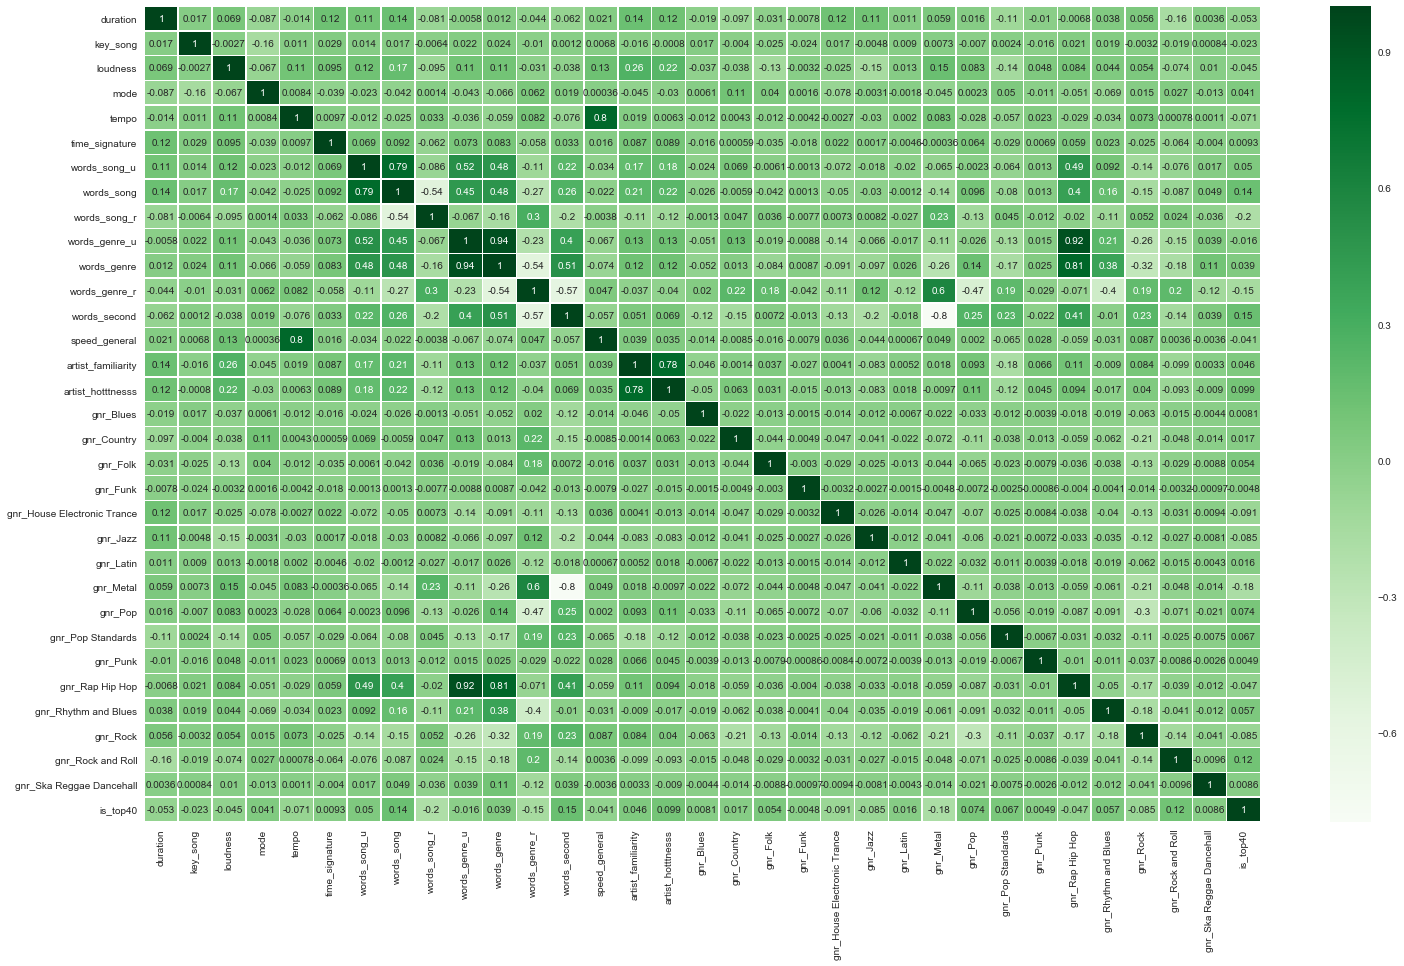

In [6]:
import seaborn as sns
corr = songs.corr()
fig, ax = plt.subplots(figsize=(25,15)) 
ax=sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True, linewidths=.5, cmap="Greens")
plt.show()

### Scatterplot

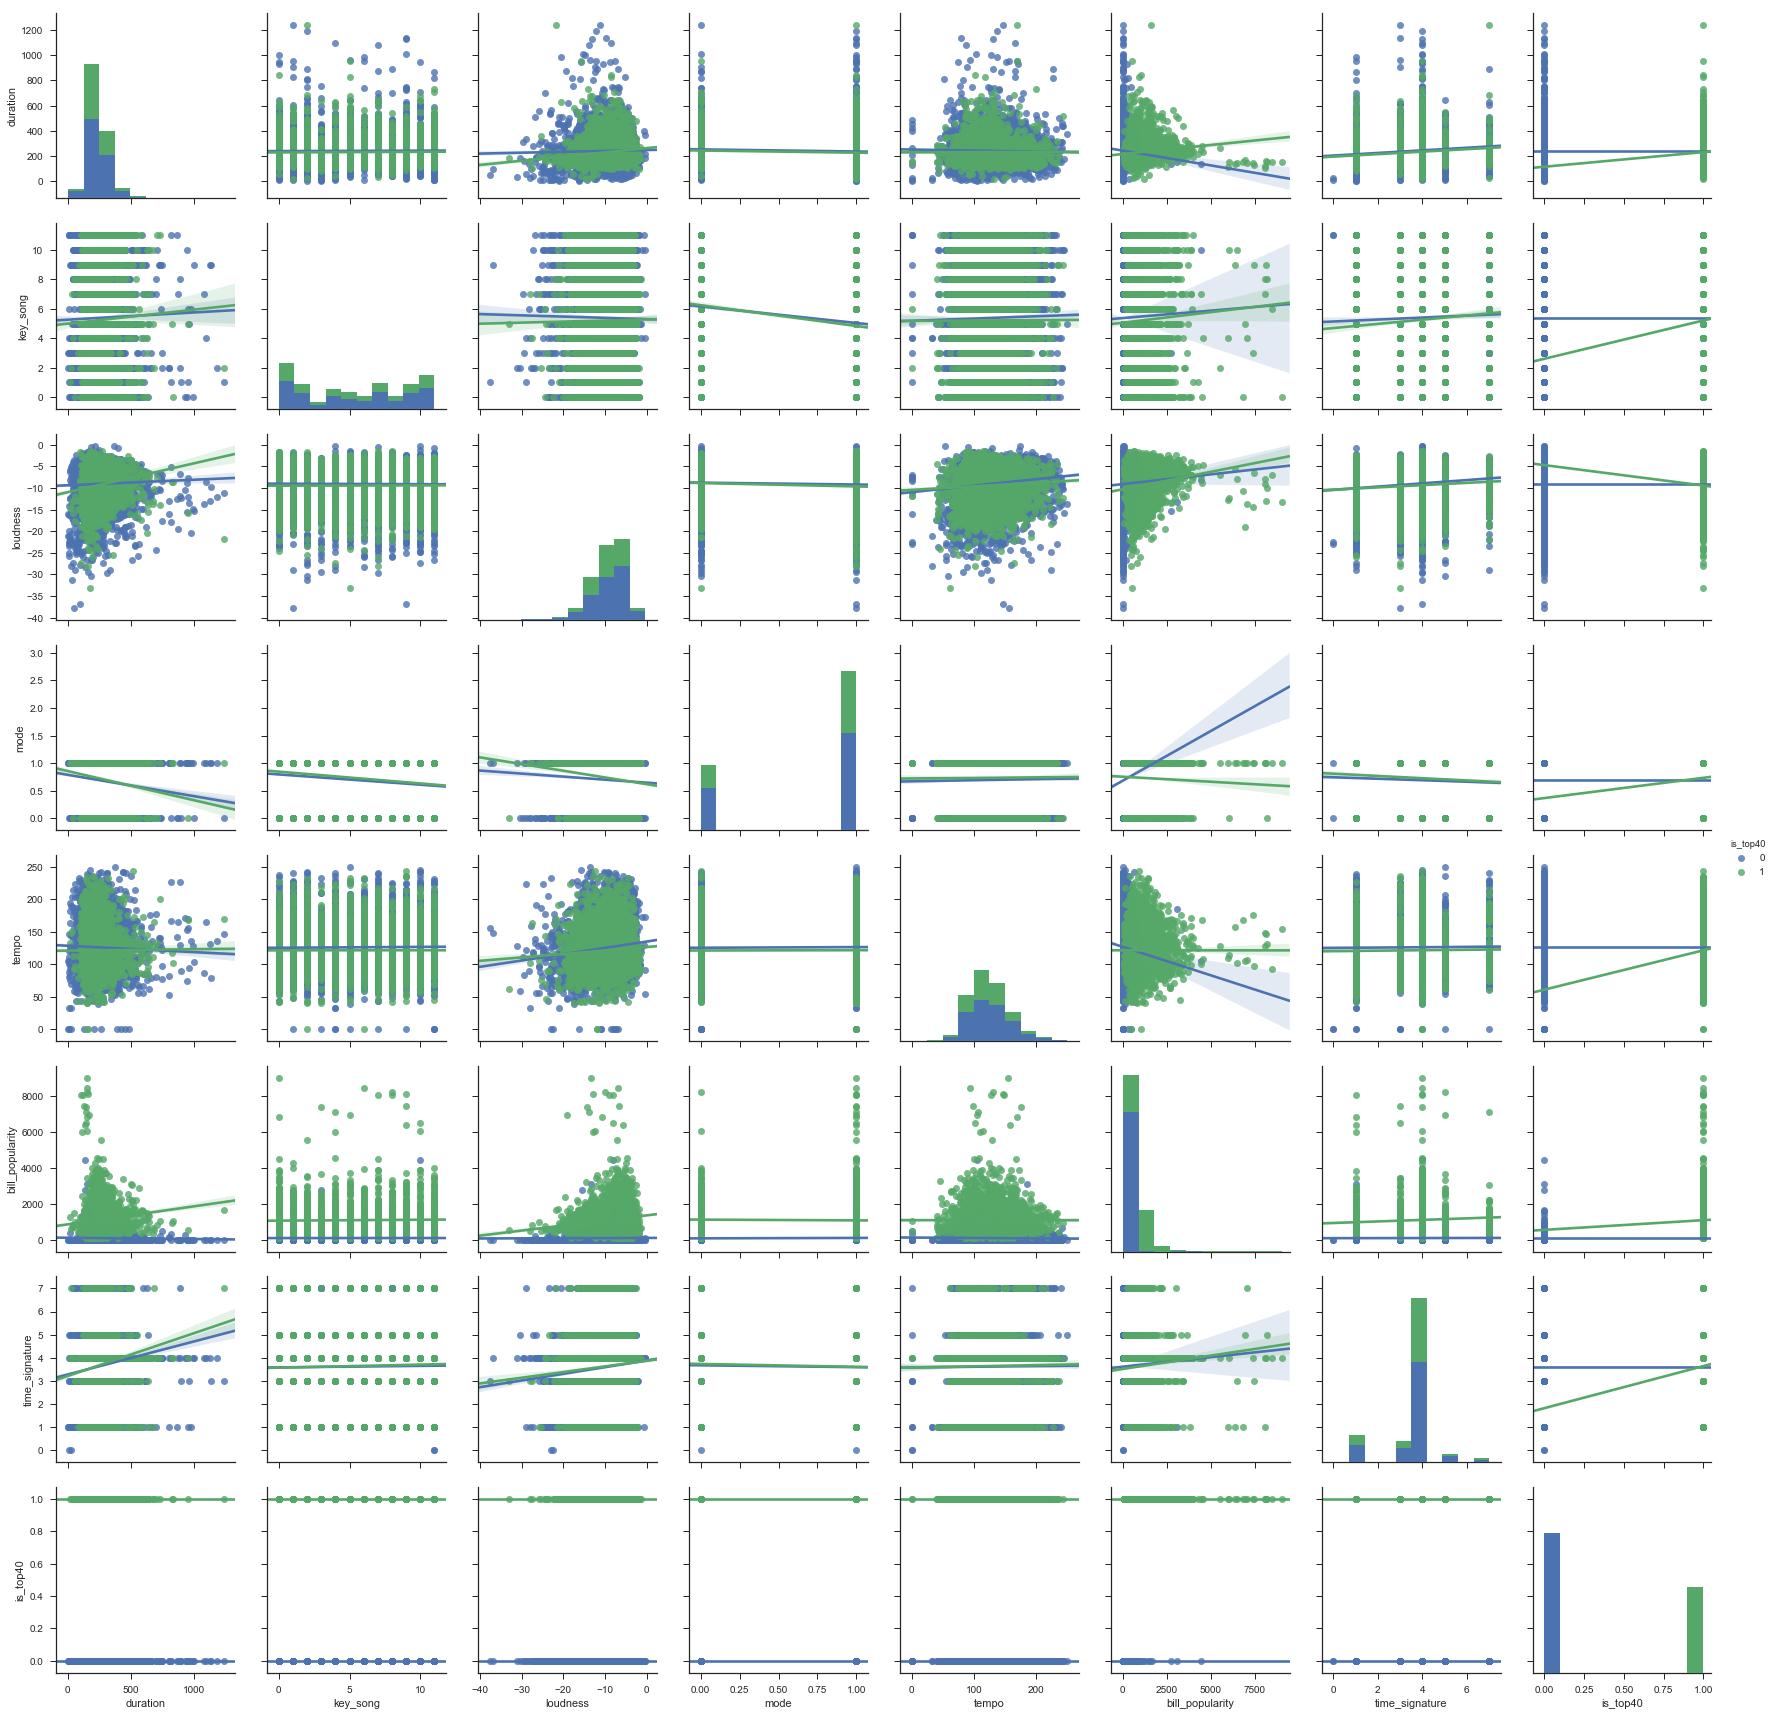

In [10]:
import seaborn as sns; sns.set(style="ticks", color_codes=True)
import matplotlib.pyplot as plt
g = sns.pairplot(songs, size=3, hue='is_top40', vars=['duration', 'key_song', 'loudness', 'mode', 'tempo', 'bill_popularity',\
                                      'time_signature','is_top40'], kind="reg")

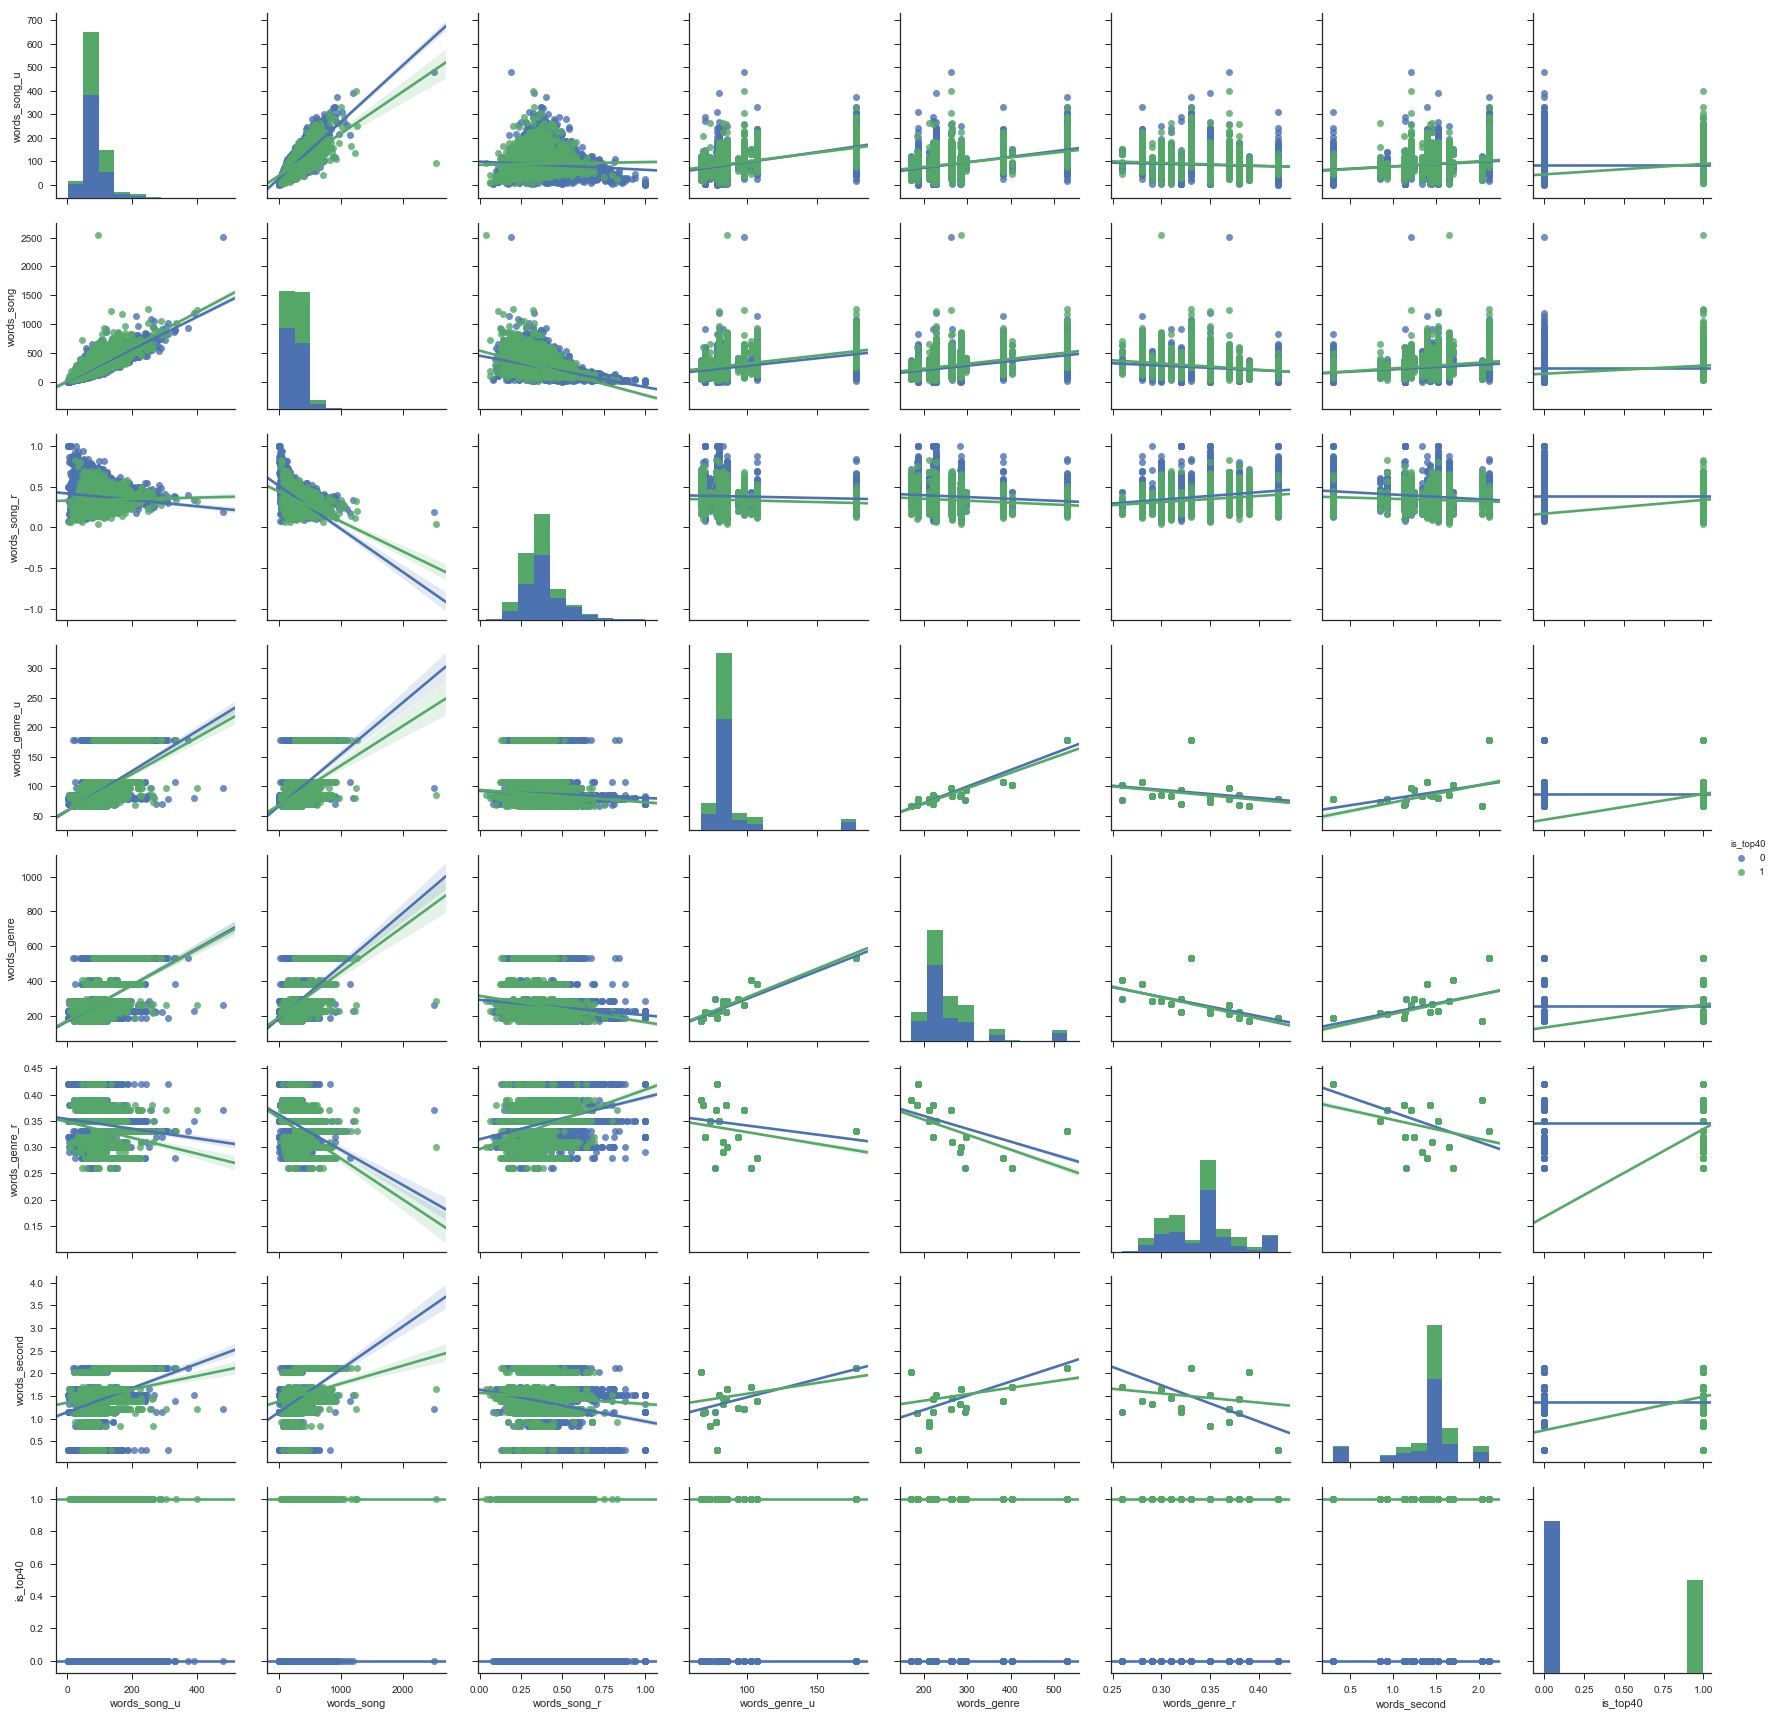

In [79]:
import seaborn as sns; sns.set(style="ticks", color_codes=True)
import matplotlib.pyplot as plt
g = sns.pairplot(songs, size=3, hue='is_top40', vars=['words_song_u','words_song', 'words_song_r', 'words_genre_u','words_genre',\
                                      'words_genre_r','words_second','is_top40'], kind="reg")

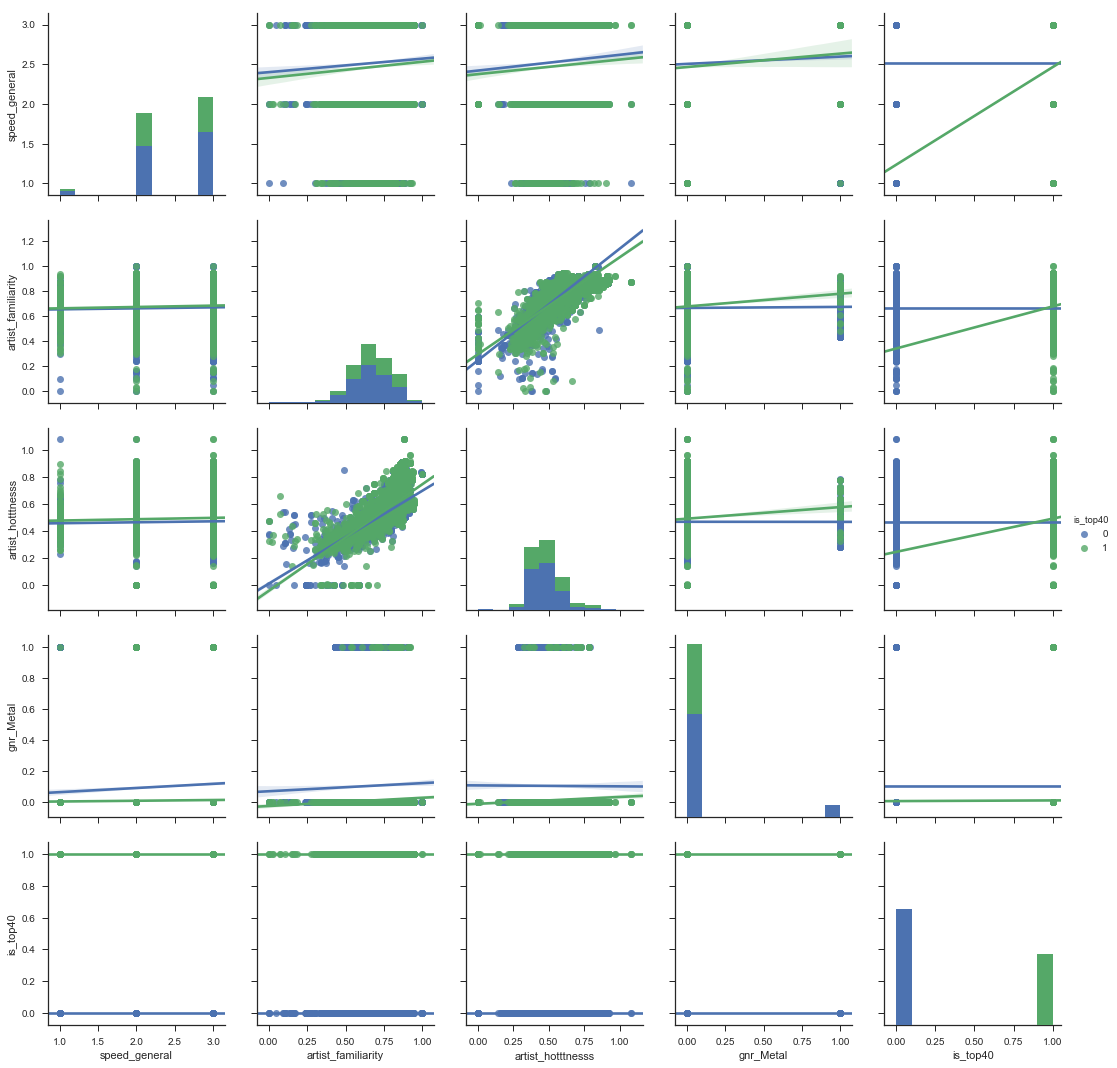

In [80]:
import seaborn as sns; sns.set(style="ticks", color_codes=True)
import matplotlib.pyplot as plt
g = sns.pairplot(songs,hue='is_top40', size=3, vars=['speed_general', 'artist_familiarity', 'artist_hotttnesss', \
            'gnr_Metal','is_top40'], kind="reg")

### Kernel Density Estimation Plots

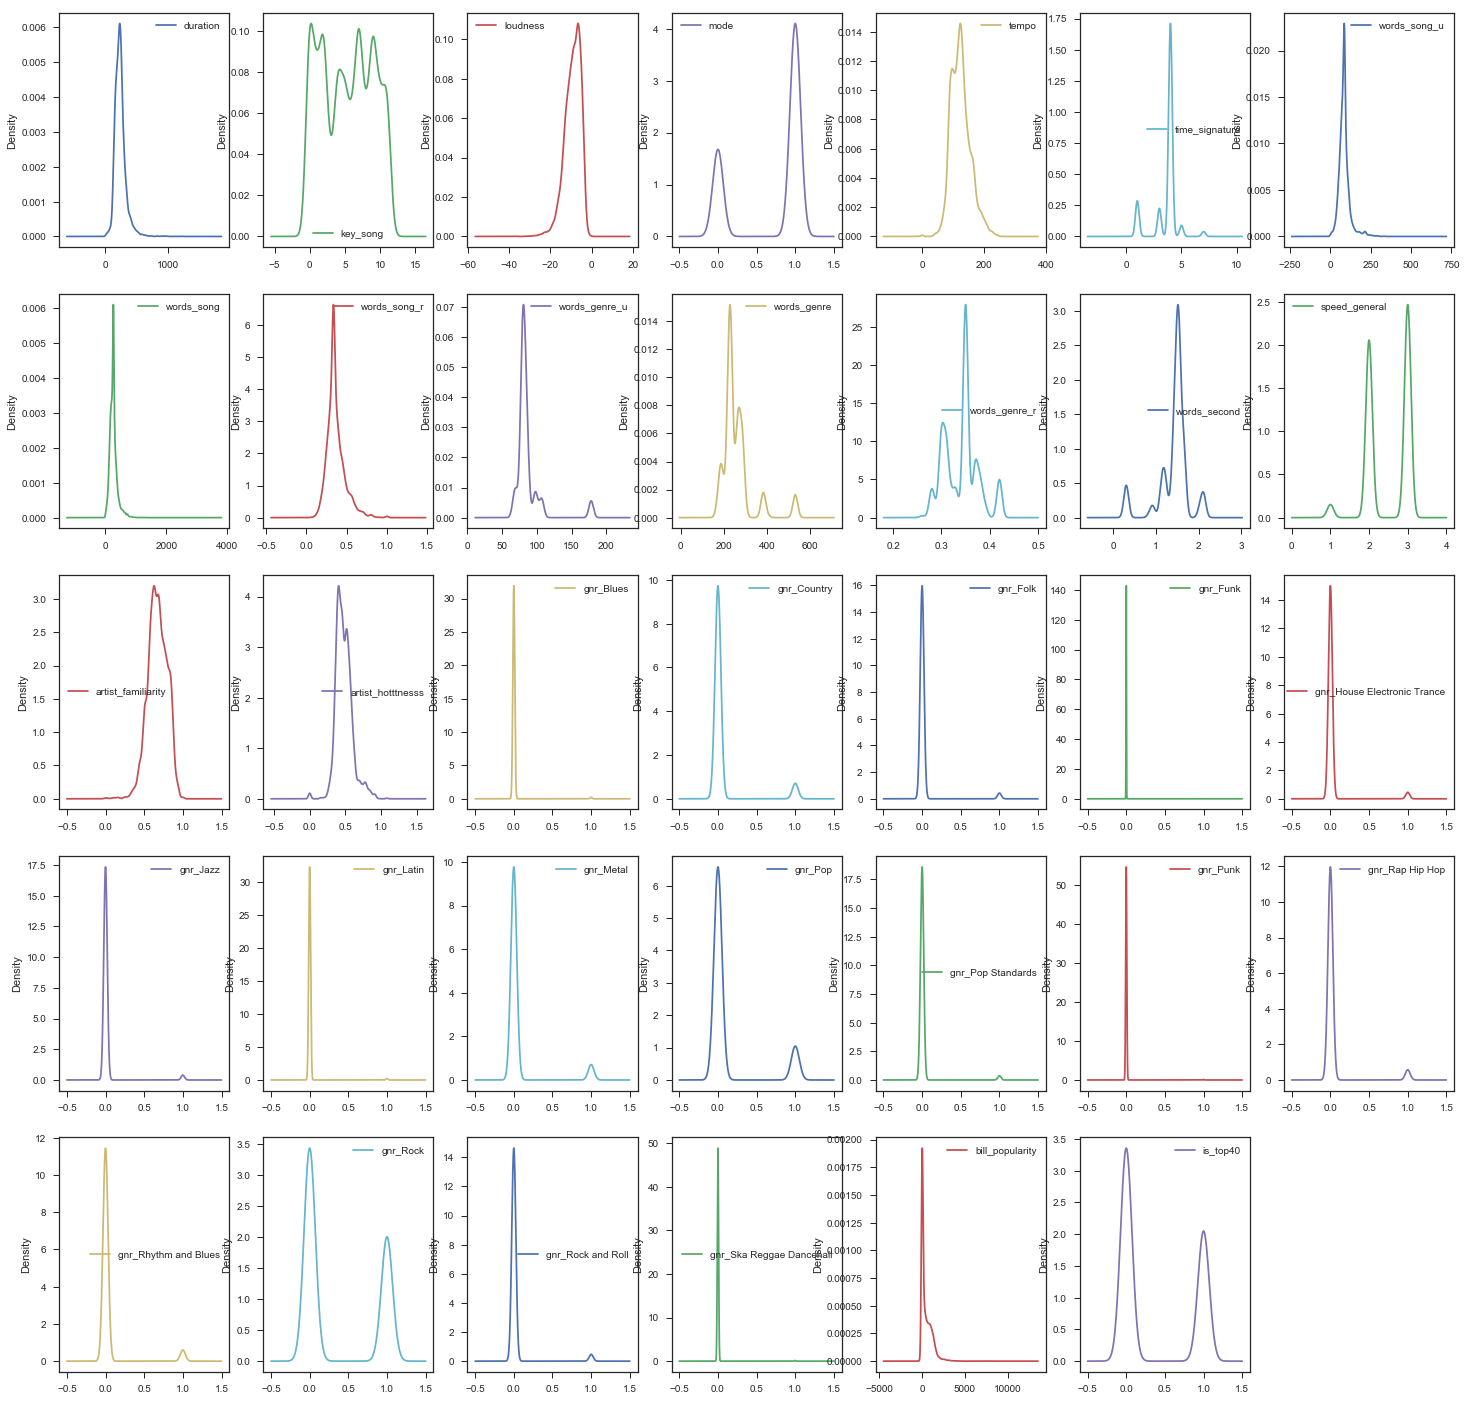

In [81]:
songs.plot(kind='kde', subplots=True, layout=(5,7), sharex=False, sharey=False, figsize=(25,25))
plt.show()

### Box Plots 

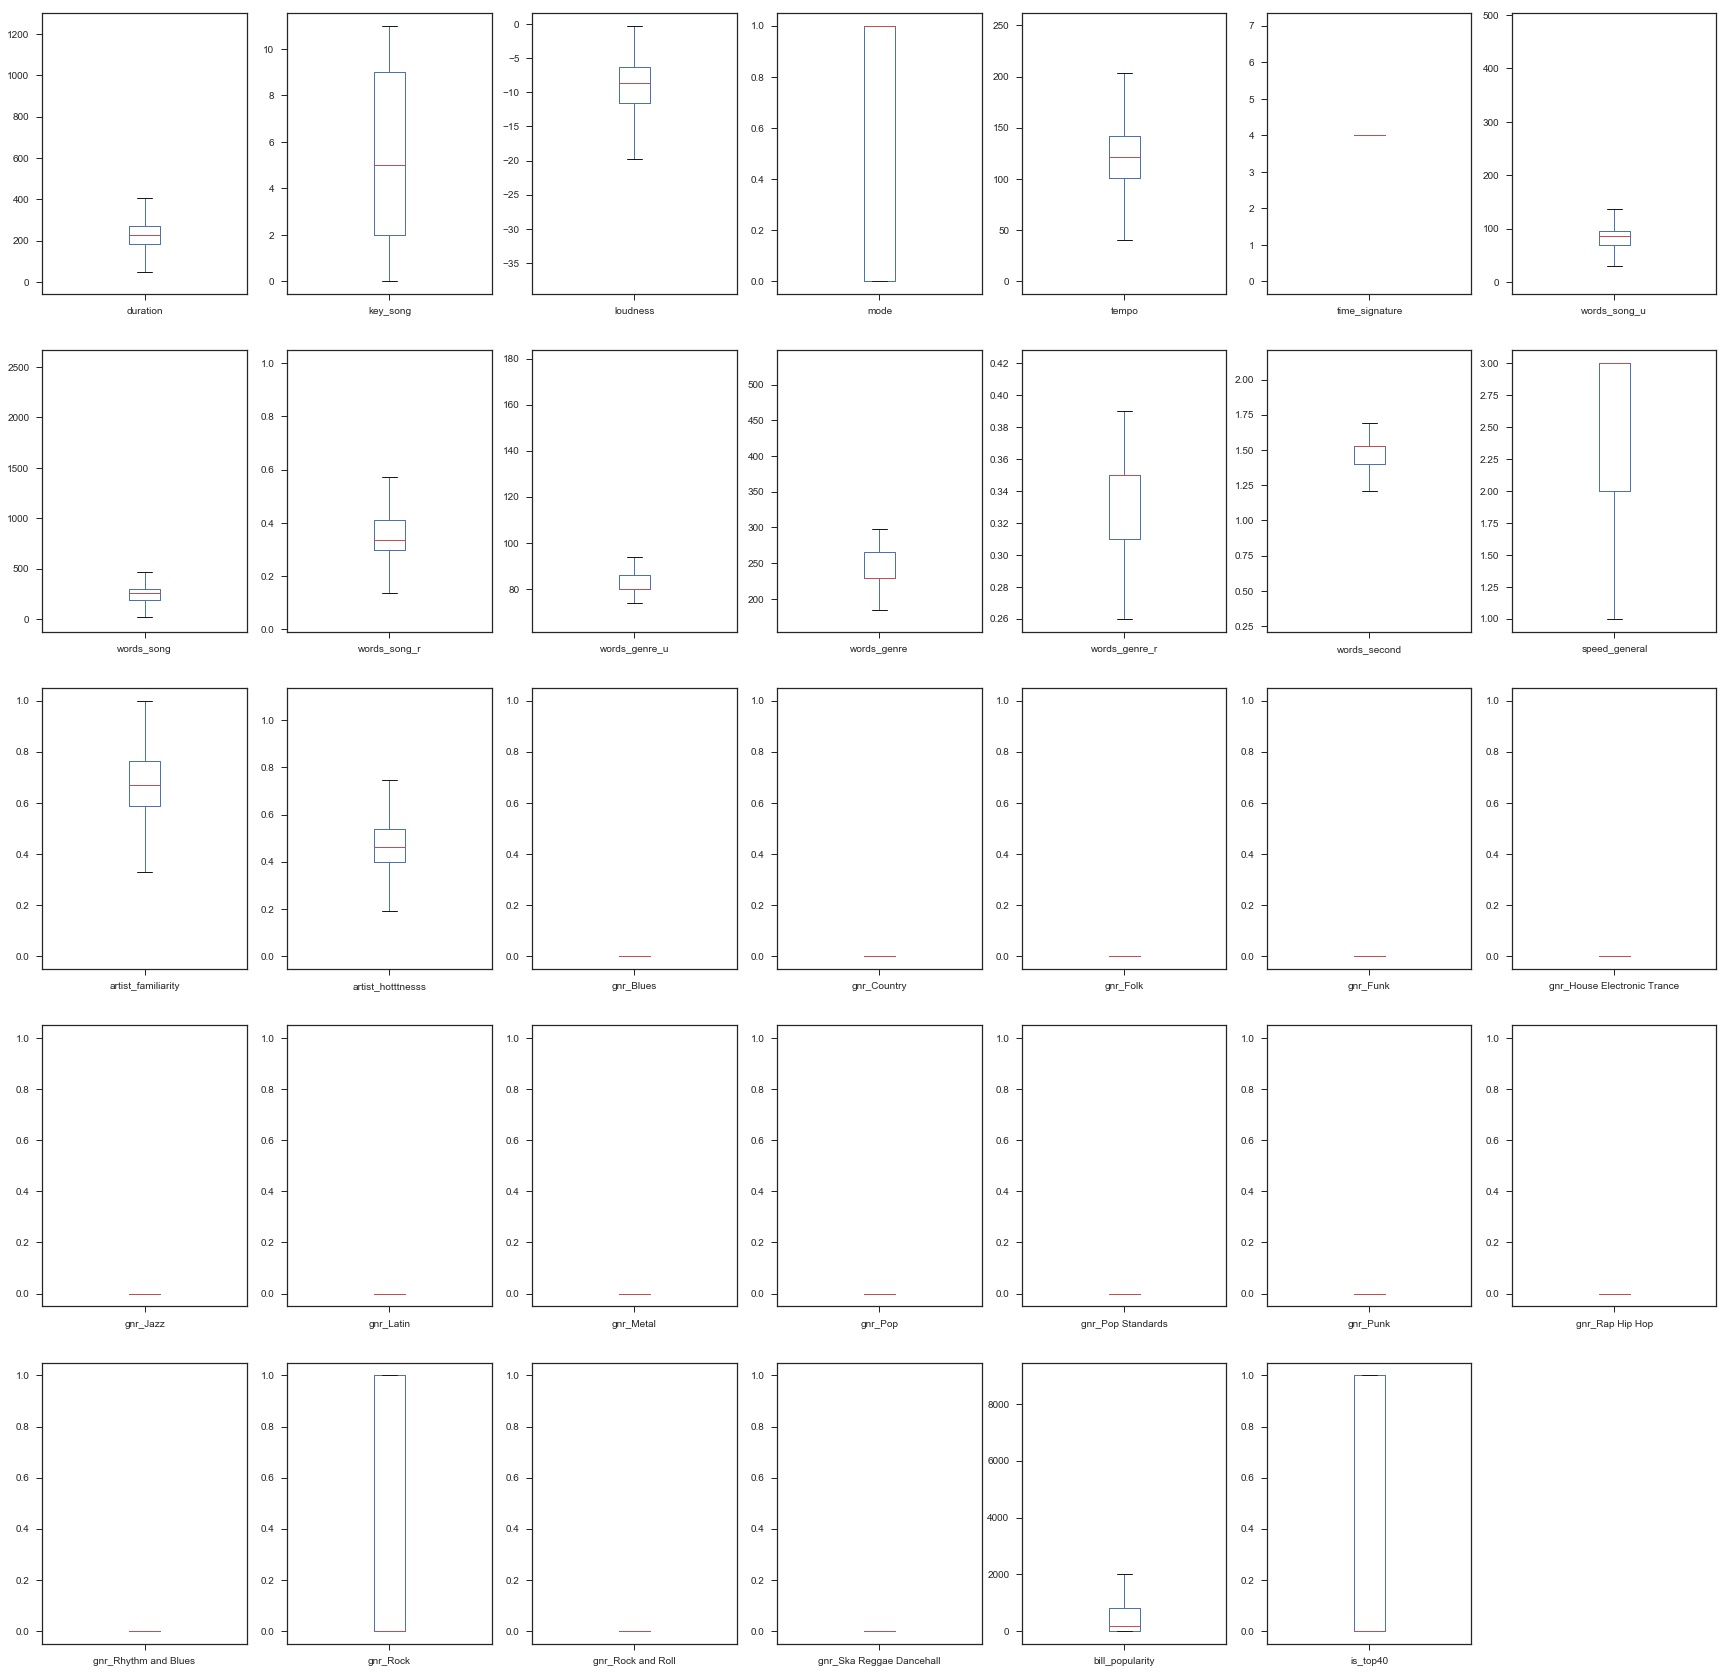

In [82]:
songs.plot(kind='box', subplots=True, layout=(5,7), sharex=False, sharey=False, figsize=(30,30))
plt.show()

### Parallel Coordinates

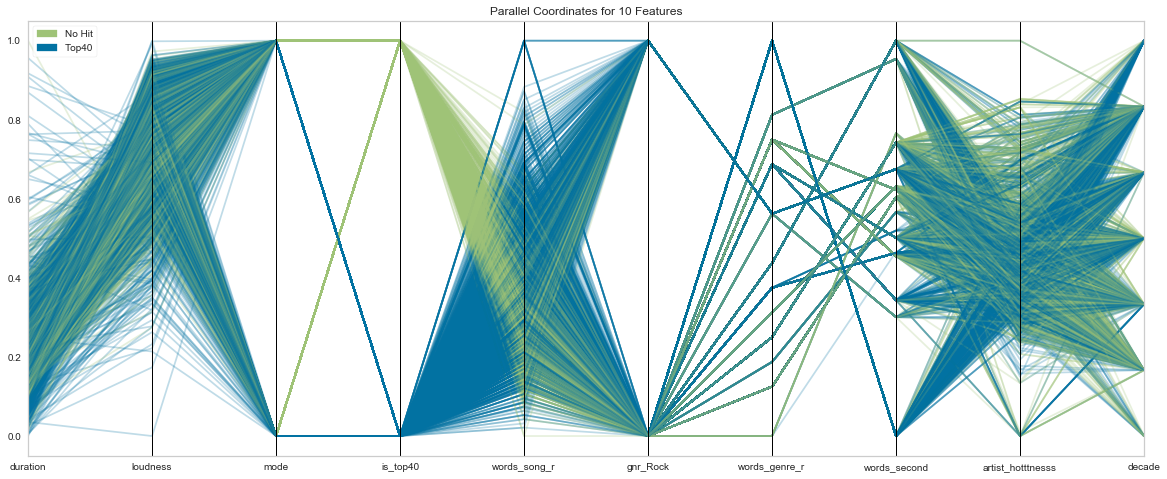

In [6]:
from yellowbrick.features import ParallelCoordinates
# features = ['duration', 'key_song', 'loudness', 'mode', 'tempo', 'time_signature', 'words_song_u', \
#             'words_song', 'words_song_r', 'words_genre_u', 'words_genre', 'words_genre_r', 'words_second', 
#             'speed_general', 'artist_familiarity', 'artist_hotttnesss', 'gnr_Metal']
classes = ["Top40", "No Hit"]

features = [ 'duration', 'loudness', 'mode','is_top40','words_song_r','gnr_Rock', 'words_genre_r',\
            'words_second',  'artist_hotttnesss','decade']
X = songs[features]
y = songs.is_top40
_, ax = plt.subplots(figsize=(20,8))
# Instantiate the visualizer
visualizer = ParallelCoordinates(
    classes=classes, features=features, normalize='minmax',sample=0.5, shuffle=True
)

# Fit and transform the data to the visualizer
visualizer.fit_transform(X, y)

# Finalize the title and axes then display the visualization
visualizer.poof()

### Rad Viz

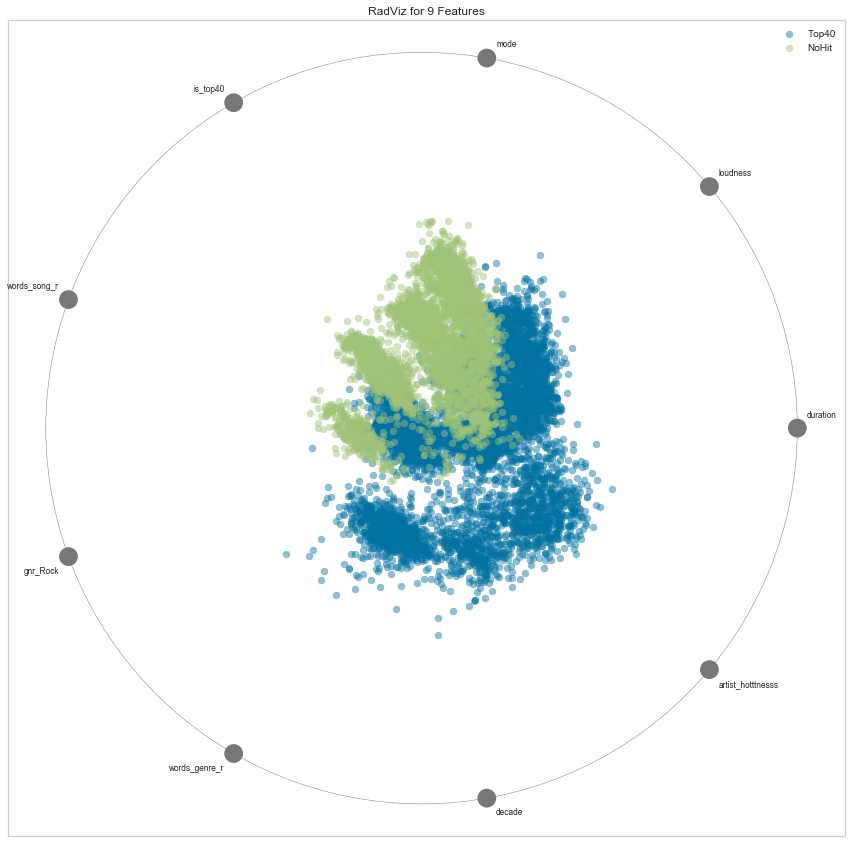

In [7]:
# Specify the features of interest and the classes of the target
classes = ["Top40", "NoHit"]
features = ['duration', 'loudness', 'mode','is_top40','words_song_r','gnr_Rock', 'words_genre_r','decade','artist_hotttnesss']
# Extract the numpy arrays from the data frame
X = songs[features].as_matrix()
Y = songs.is_top40.as_matrix()
# Import the visualizer
from yellowbrick.features import RadViz

# Instantiate the visualizer
_,ax = plt.subplots(figsize=(15,15))
visualizer = RadViz(classes=classes, features=features, alpha=0.45)

visualizer.fit(X, Y)      # Fit the data to the visualizer
visualizer.transform(X)   # Transform the data
visualizer.poof()         # Draw/show/poof the data

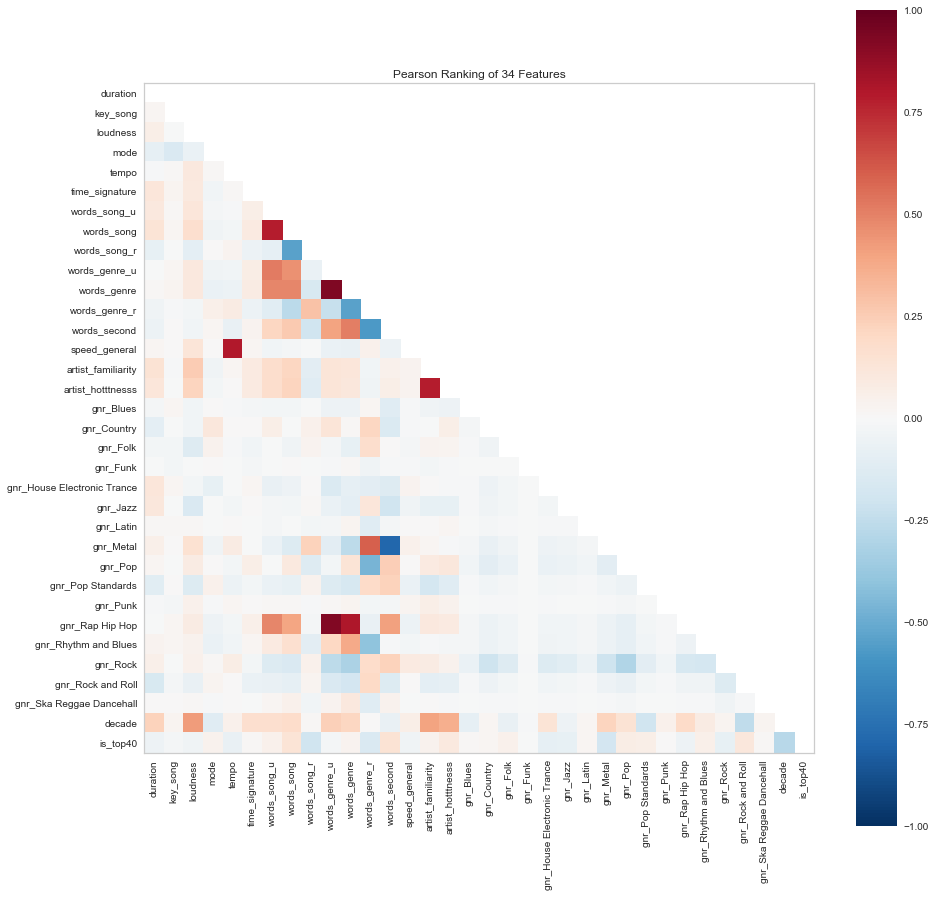

In [26]:
from yellowbrick.features import Rank2D


features = ['duration', 'key_song', 'loudness', 'mode', 'tempo', 'time_signature', 'words_song_u', 'words_song', \
             'words_song_r', 'words_genre_u', 'words_genre', 'words_genre_r', 'words_second', 'speed_general', \
             'artist_familiarity', 'artist_hotttnesss', 'gnr_Blues', 'gnr_Country', 'gnr_Folk', 'gnr_Funk', \
             'gnr_House Electronic Trance', 'gnr_Jazz', 'gnr_Latin', 'gnr_Metal', 'gnr_Pop', 'gnr_Pop Standards', \
             'gnr_Punk', 'gnr_Rap Hip Hop', 'gnr_Rhythm and Blues', 'gnr_Rock', 'gnr_Rock and Roll', \
             'gnr_Ska Reggae Dancehall','decade','is_top40']
X = songs[features].as_matrix()
y = songs.is_top40.as_matrix()
# Instantiate the visualizer with the Covariance ranking algorithm
_,ax = plt.subplots(figsize=(15,15))
visualizer = Rank2D(features=features, algorithm='pearson')

visualizer.fit(X, y)                # Fit the data to the visualizer
visualizer.transform(X)             # Transform the data
visualizer.poof()                   # Draw/show/poof the data

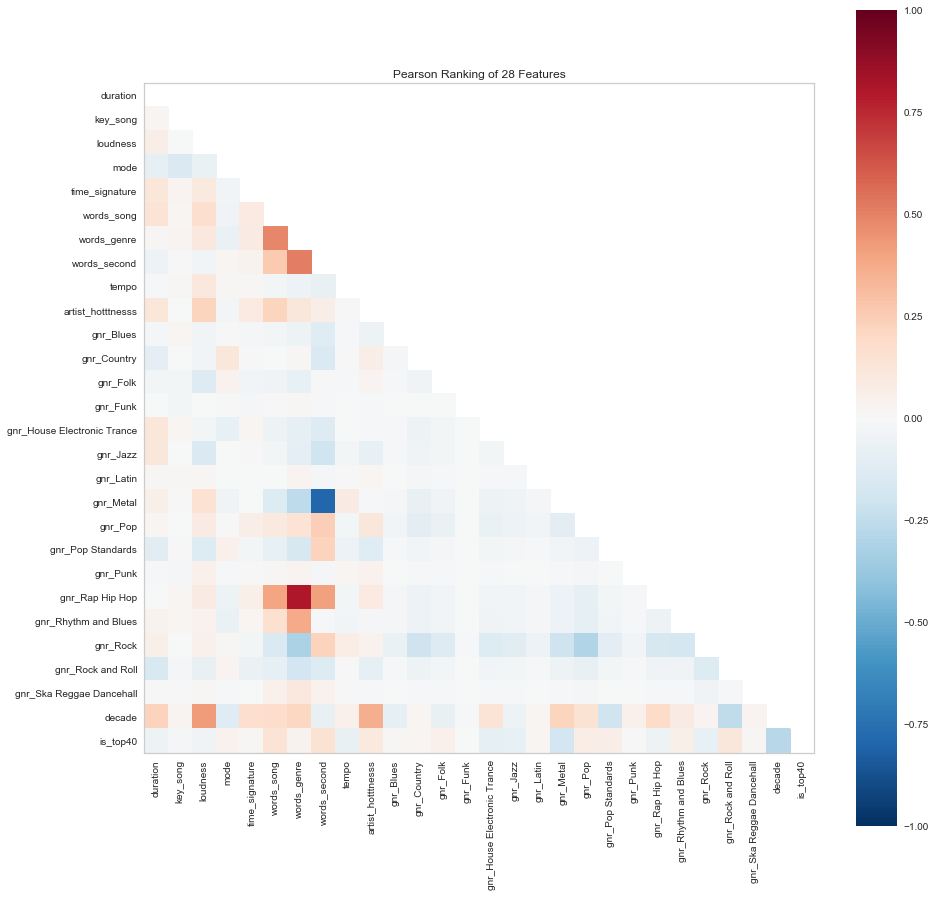

In [27]:
less_features = ['duration', 'key_song', 'loudness', 'mode','time_signature', \
             'words_song','words_genre', 'words_second', 'tempo', \
             'artist_hotttnesss', 'gnr_Blues', 'gnr_Country', 'gnr_Folk', 'gnr_Funk', \
             'gnr_House Electronic Trance', 'gnr_Jazz', 'gnr_Latin', 'gnr_Metal', 'gnr_Pop', 'gnr_Pop Standards', \
             'gnr_Punk', 'gnr_Rap Hip Hop', 'gnr_Rhythm and Blues', 'gnr_Rock', 'gnr_Rock and Roll', \
             'gnr_Ska Reggae Dancehall','decade','is_top40']
X1 = songs[less_features].as_matrix()
Y1 = songs.is_top40.as_matrix()
# Instantiate the visualizer with the Covariance ranking algorithm
_,ax = plt.subplots(figsize=(15,15))
visualizer = Rank2D(features=less_features, algorithm='pearson')

visualizer.fit(X1, Y1)                # Fit the data to the visualizer
visualizer.transform(X1)             # Transform the data
visualizer.poof()     

# Initial Model Comparison

### Split-Out validation dataset

In [33]:
songs = df [['duration', 'key_song', 'loudness', 'mode', 'tempo', 'time_signature', 'words_song_u', 'words_song', \
             'words_song_r', 'words_genre_u', 'words_genre', 'words_genre_r', 'words_second', 'speed_general', \
             'artist_familiarity', 'artist_hotttnesss', 'gnr_Blues', 'gnr_Country', 'gnr_Folk', 'gnr_Funk', \
             'gnr_House Electronic Trance', 'gnr_Jazz', 'gnr_Latin', 'gnr_Metal', 'gnr_Pop', 'gnr_Pop Standards', \
             'gnr_Punk', 'gnr_Rap Hip Hop', 'gnr_Rhythm and Blues', 'gnr_Rock', 'gnr_Rock and Roll', \
             'gnr_Ska Reggae Dancehall','decade','is_top40']]
array = songs.values
X = array[:,0:-1]
Y = array[:,-1] #is_top40
    
validation_size = 0.2
seed = 7
X_train, X_validation, Y_train, Y_validation = model_selection.train_test_split(X, Y,test_size=validation_size,random_state=seed)
songs.shape

(12255, 34)

  ### Test options and evaluation metric

In [35]:
seed = 7

scoring = 'f1_weighted'

In [30]:
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV

from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import RadiusNeighborsClassifier

from sklearn.svm import SVC
from sklearn.svm import NuSVC
from sklearn.svm import LinearSVC

from sklearn.ensemble import AdaBoostClassifier

from sklearn.neural_network import MLPClassifier

### HyperParameter Tuning with GridSearchCV

In [ ]:
from __future__ import print_function

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

print(__doc__)



# Specify the features of interest and the target
target = 'is_top40'
features = [col for col in data.columns if col != target]

# Encode the categorical data with one-hot encoding
X = data[features]
y = data[target]

# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.5, random_state=0)

# Set the parameters by cross-validation
#RandomForest
# tuned_parameters = [{'criterion': ['entropy','gini'], 'n_estimators': [1, 5, 10, 100],
#  'max_depth': [1, 2, 3, 4, 5, 7, 9, 12]},
# {'warm_start': [True, False], 'max_features': ['auto']}]

#LDA
# tuned_parameters = [{'n_components': [None,1, 10, 20, 30], 'tol': [0.0001,0.001,0.01,0.1],
#  'solver': ['svd','lsqr']}]
#QDA
# tuned_parameters = [{'reg_param': [0.001,0.001,0.01,0.1,1.0], 'tol': [0.0001,0.001,0.01,0.1],
#  'store_covariance': [True,False]}]

#Logistic Regression
# tuned_parameters = [{'penalty': ['l2'], 'C': [0.1, 1.0, 1.5, 2.5, 5.0],
#  'random_state': [1,3,5,7,12],'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 'tol': [0.0001,0.001,0.01,0.1],},
# {'warm_start': [True, False]}]

#Logistic Regression CV
tuned_parameters = [{'Cs': [1,2,3,4,5], 'cv': [10,12],'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 'tol': [0.0001,0.001,0.01,0.1],},
{'refit': [True, False]}]
scores = ['f1']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(SVC(), tuned_parameters, cv=5,
                       scoring='%s_macro' % score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()


### Selected Algorithms

In [31]:
models = []
# #Naive Bayes,
#models.append(('NB', GaussianNB(priors = [0.99,0.01])))
#models.append(('BNB', BernoulliNB(alpha = 0.001, binarize = 0.95, class_prior = [0.8,0.2], fit_prior = True)))
# # #Decision Tree,
# models.append(('CART',DecisionTreeClassifier(criterion = 'entropy', splitter='random',
#                                              max_depth = 10,max_leaf_nodes = 12,
#                                              min_impurity_decrease = 0.35, random_state = 7)))
models.append(('RFC', RandomForestClassifier(bootstrap = True, class_weight = None, criterion = 'gini', max_features = 'auto',
                                             max_leaf_nodes =None,n_estimators = 120, warm_start = False, random_state = 7)))

# Discriminant Analysis,
#models.append(('LDA', LinearDiscriminantAnalysis(n_components= 0, solver= 'svd', store_covariance= True, tol= 0.0001)))


# #LogisticRegression,
# {'C': 1.5, 'penalty': 'l2', 'random_state': 1, 'solver': 'newton-cg', 'tol': 0.0001},
models.append(('LRG', LogisticRegression(C= 1.1, class_weight= 'balanced', dual= False, fit_intercept= True, max_iter= 90, multi_class= 'ovr', n_jobs= 1, penalty= 'l2', random_state= 2, solver= 'liblinear', tol= 0.0001, verbose= 0, warm_start= False)))
#{'Cs': 2, 'cv': 10, 'solver': 'liblinear', 'tol': 0.1},
#models.append(('LCV', LogisticRegressionCV(Cs= 10, class_weight= 'balanced', cv= 5, dual= False, fit_intercept= True, intercept_scaling= 1, max_iter= 120, multi_class= 'ovr', n_jobs= 1, penalty= 'l1', random_state= 2, refit= True, solver= 'liblinear', tol=0.0001, verbose= 2)))

#KNN,
#models.append(('KNN', KNeighborsClassifier(algorithm = 'ball_tree', leaf_size =20,  metric = 'minkowski',n_neighbors=7, 
#                             p = 2, weights='uniform', n_jobs= -1)))
#models.append(('NCT', NearestCentroid()))
#models.append(('KNN', NearestNeighbors()))
#models.append(('RNC', RadiusNeighborsClassifier(radius=5.0, outlier_label=1)))
#Support Vector Machine,
#models.append(('SVM', SVC()))#(kernel='linear', C=0.025))) 
# models.append(('NuSVM', NuSVC()))
# models.append(('LinearSVC', LinearSVC(C=0.75, max_iter=2000))) 
models.append(('ABC',AdaBoostClassifier()))
#{'activation': 'identity', 'learning_rate': 'constant', 'max_iter': 500, 'random_state': 7, 'shuffle': True, 'solver': 'lbfgs'}
#models.append(('Neural Network',MLPClassifier()))#activation='identity',learning_rate='constant',#max_iter=500,
#                                              random_state=7,shuffle=True,
#                                               solver='lbfgs')))
#LogisticRegressionCV().get_params(deep = True),

# alpha_spc = np.linspace(0.0,0.5,num=10, endpoint=True)
# for a in range(len(alpha_spc)):
# models.append(('CART'+str(alpha_spc[a]),DecisionTreeClassifier(criterion = 'entropy', splitter='random', max_depth =10,max_features= 13,
#max_leaf_nodes = 12, min_impurity_split = 0.35, random_state = 7,
#min_weight_fraction_leaf = int(alpha_spc[a]))))
# print(str(alpha_spc[a]))



# KNeighborsClassifier().get_params(deep = True)
# n_neighbors = np.linspace(1,12,num=12, endpoint=True)
# for a in range(len(n_neighbors)):
#     models.append(('KNC'+ str(int(n_neighbors[a])), KNeighborsClassifier(algorithm = 'auto', metric = 'minkowski', n_jobs= -1, n_neighbors= int(n_neighbors[a]))))
    
# print(models)
                                                                       


# import numpy as np
# from yellowbrick.model_selection import ValidationCurve

# pr = np.linspace(1, 5, num=5, endpoint=True)
# print(np.linspace(1, 5, num=5, endpoint=True))
# model = ValidationCurve(KNeighborsClassifier(), param_name="n_neighbors", param_range=pr)
# model.fit(X_train, Y_train)
# model.poof()


In [17]:
RandomForestClassifier().get_params(deep = True)

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': 1,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

### Initial Evaluation Each Model in Turn

In [36]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing.data import QuantileTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

results = []
names = []

# print('\nTest Accuracy with Scaling and PCA\n')
# start_time = time.time()
# for name, model in models:
#     pipe_mdl = make_pipeline(StandardScaler(),
#                         PCA(n_components=18),
#                         model)
#     pipe_mdl.fit(X_train, Y_train)
#     y_pred = pipe_mdl.predict(X_validation)
#     pipe_results =pipe_mdl.score(X_validation, Y_validation)
#     print('%s Test Accuracy: %f' % (name, pipe_results))
# print('--- %s seconds ---' % (time.time() - start_time))    
# print()



#print('\nTest Accuracy with Stratified KFold within Pipeline \n')
# from sklearn.model_selection import StratifiedKFold
# for name, model in models:
#     pipe_mdl = make_pipeline(StandardScaler(),
#                         PCA(n_components=18),
#                         model)
#     kfold = model_selection.StratifiedKFold(n_splits=10, random_state=1).split(X_train,Y_train)
#     scores = []
#     mnames = []
#     for k, (train,test) in enumerate(kfold):
#         pipe_mdl.fit(X_train[train],Y_train[train])
#         score = pipe_mdl.score(X_train[test],Y_train[test])
#         #print('Fold: %2d,  Acc: %.3f' % (k+1,score))
#         scores.append(score)
#         mnames.append(name)
#     print('%s CV accuracy: %.3f +/- %.3f' %(name, np.mean(scores), np.std(scores)))

from sklearn.model_selection import cross_val_score
res_scores = []
m_names = []
for name, model in models:
    start_time = time.time()
    print(name)
    pipe_mdl = make_pipeline(QuantileTransformer(),
                        PCA(n_components=18),
                        model)
    kfold = model_selection.KFold(n_splits=12, random_state=7)
    scores = model_selection.cross_val_score(estimator=pipe_mdl,
                         X=X_train,
                         y=Y_train,
                         cv=kfold,
                         #n_jobs=-1,
                         scoring = scoring)
    print('CV accuracy: %.5f +/- %.5f' % (np.mean(scores),np.std(scores)))
    res_scores.append(scores)
    m_names.append(name)
    print('--- %s seconds ---' % (time.time() - start_time))


# print('\nTest Accuracy with KFold Test \n')
# start_time = time.time()
# for name, model in models:    
#     kfold = model_selection.KFold(n_splits=10, random_state=1)
#     cv_results = model_selection.cross_val_score(model, X_validation, Y_validation, cv=kfold, scoring=scoring)
#     results.append(cv_results)
#     names.append(name)
#     msg = '%s: %.3f +/- (%.3f)'% (name, cv_results.mean(), cv_results.std())
#     print(msg)
# print('--- %s seconds ---' % (time.time() - start_time))

RFC
CV accuracy: 0.69251 +/- 0.01645
--- 41.15448021888733 seconds ---
LRG
CV accuracy: 0.68556 +/- 0.01983
--- 1.6597089767456055 seconds ---
ABC
CV accuracy: 0.67887 +/- 0.01933
--- 12.65755009651184 seconds ---


### Compare Algorithms

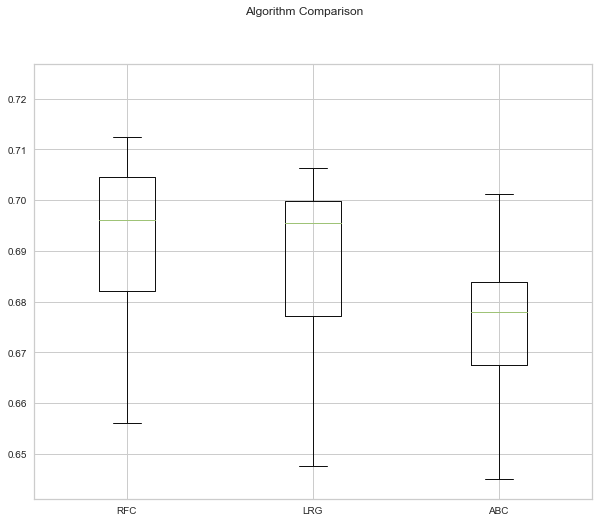

In [37]:
fig = plt.figure(figsize=(10, 8))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(res_scores)
ax.set_xticklabels(m_names)
plt.show()

### Applying the Visualization to the Models

RFC
0.7254181966544268
[[1230  291]
 [ 382  548]]


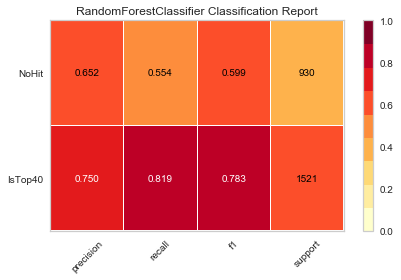

LRG
0.6474908200734394
[[954 567]
 [297 633]]


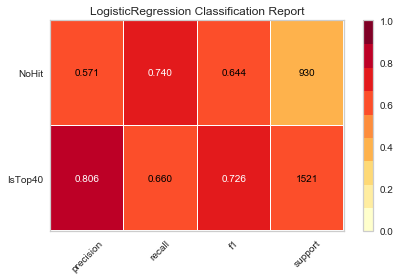

ABC
0.6870665034679723
[[1188  333]
 [ 434  496]]


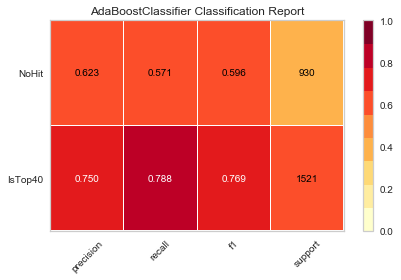

In [46]:
from yellowbrick.classifier import ClassificationReport
classes = ["IsTop40", "NoHit"]


def plotting(name, model):
    model.fit(X_train, Y_train)
    predictions = model.predict(X_validation)
    print(name)
    print(accuracy_score(Y_validation, predictions))
    print(confusion_matrix(Y_validation, predictions))
    pipe_mdl = make_pipeline(QuantileTransformer(),
                        PCA(n_components=28),
                        model)
    visualizer = ClassificationReport(pipe_mdl, classes=classes, support=True)
    visualizer.fit(X_train, Y_train)  # Fit the visualizer and the model
    visualizer.score(X_validation, Y_validation)  # Evaluate the model on the test data
    g = visualizer.poof()             # Draw/show/poof the data
    
for name, model in models:
    plotting(name, model)

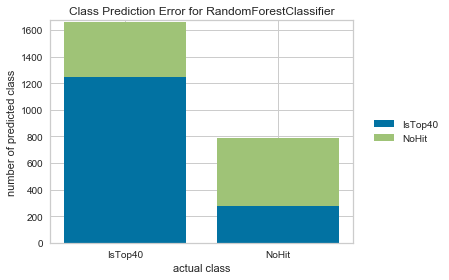

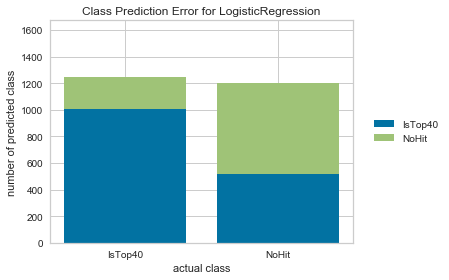

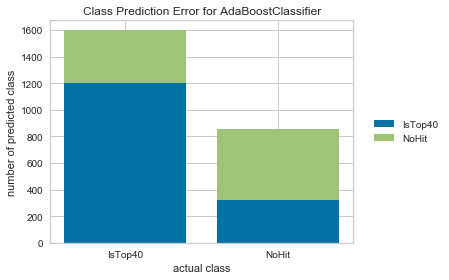

In [48]:
from sklearn.linear_model import Lasso
from yellowbrick.classifier import ClassPredictionError

def vizerror(name, model):
    # Instantiate the visualizer
    pipe_mdl = make_pipeline(QuantileTransformer(),
                        PCA(n_components=28),
                        model)
    visualizer = ClassPredictionError(
        pipe_mdl, classes=classes)
    # Fit
    visualizer.fit(X_train, Y_train)
    # Score and visualize
    visualizer.score(X_validation, Y_validation)
    visualizer.poof()
    
for name, model in models:
    vizerror(name, model)

### ROC AUC Curve

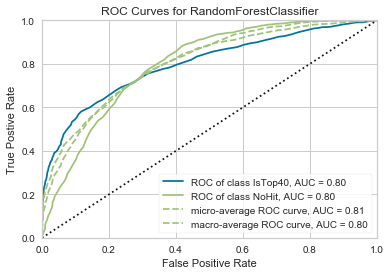

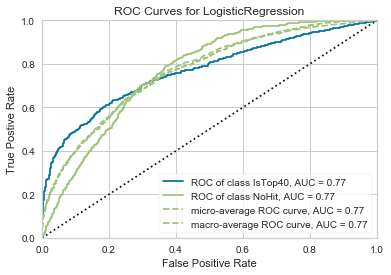

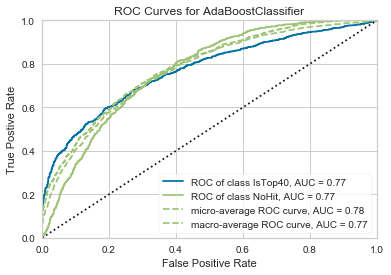

In [49]:
from sklearn.linear_model import LogisticRegression

from yellowbrick.classifier import ROCAUC

def vizerror(name, model):
    # Instantiate the visualizer
    pipe_mdl = make_pipeline(QuantileTransformer(),
                        PCA(n_components=28),
                        model)
    visualizer = ROCAUC(pipe_mdl, classes=classes)
    # Fit
    visualizer.fit(X_train, Y_train)
    # Score and visualize
    visualizer.score(X_validation, Y_validation)
    visualizer.poof()
    
for name, model in models:
    vizerror(name, model)

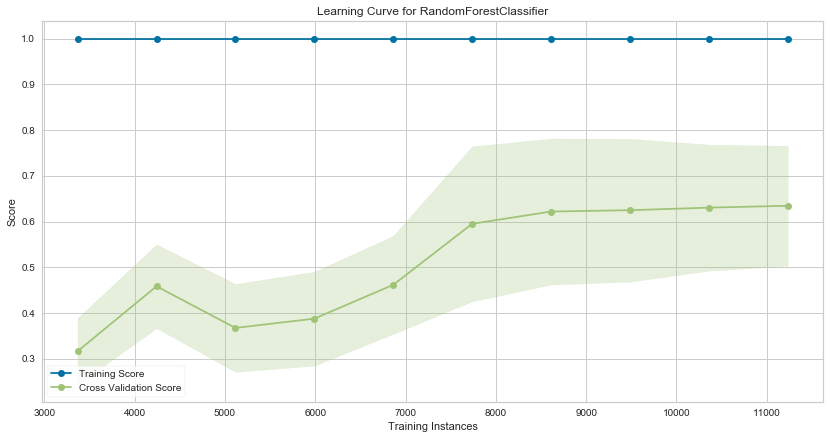

--- 446.4461040496826 seconds ---


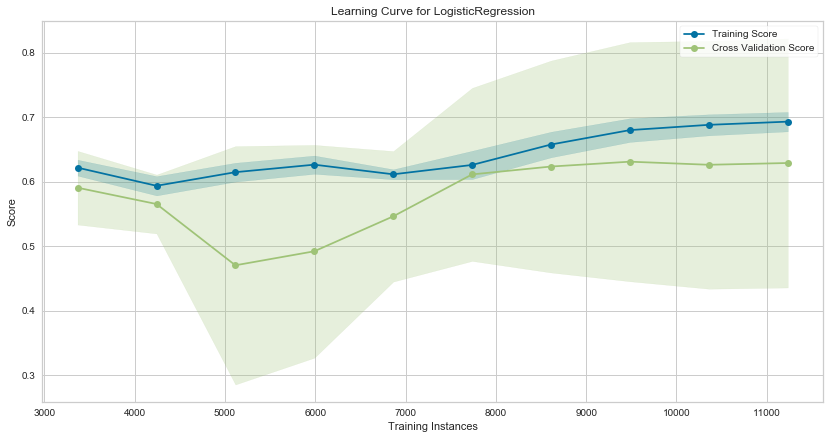

--- 20.772223949432373 seconds ---


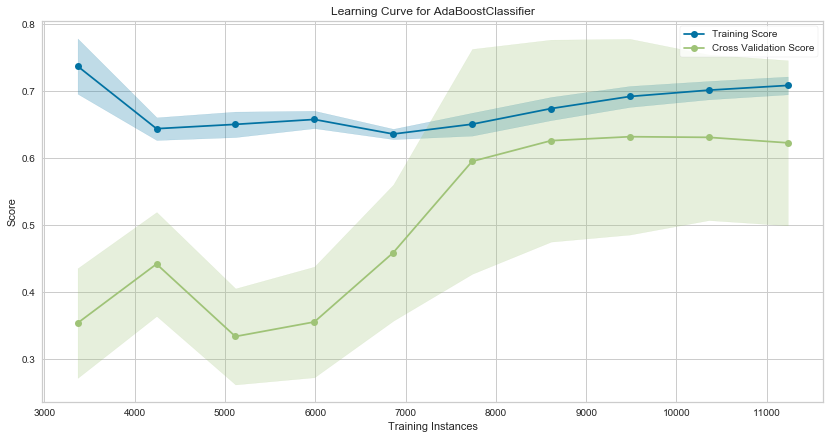

--- 154.36361384391785 seconds ---


In [50]:
from sklearn.model_selection import StratifiedKFold
from yellowbrick.model_selection import LearningCurve

def vizerror(name, model):
    # Instantiate the visualizer
    pipe_mdl = make_pipeline(QuantileTransformer(),
                        PCA(n_components=28),
                        model)
    # Create the learning curve visualizer
    cv = StratifiedKFold(12)
    
    sizes = np.linspace(0.3, 1.0, 10)
    _,ax = plt.subplots(figsize=(14,7))
    viz = LearningCurve(
        pipe_mdl, cv=cv, train_sizes=sizes,
        scoring=scoring)
    # Fit and poof the visualizer
    viz.fit(X, Y)
    viz.poof()
    
    
for name, model in models:
    start_time = time.time()
    vizerror(name, model)
    print('--- %s seconds ---' % (time.time() - start_time))

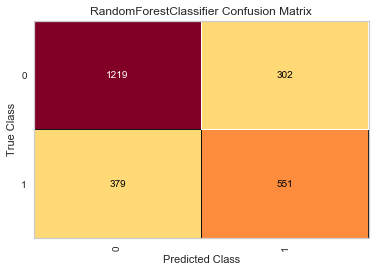

--- 1.7485289573669434 seconds ---


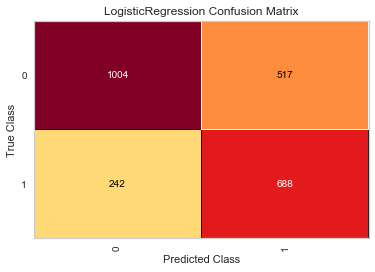

--- 0.2612791061401367 seconds ---


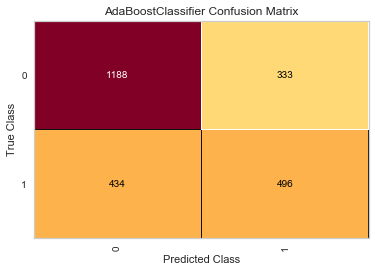

--- 0.728874921798706 seconds ---


In [24]:
from yellowbrick.classifier import ConfusionMatrix
def vizerror(name, model):
    # Instantiate the visualizer
    pipe_mdl = make_pipeline(QuantileTransformer(),
                        #PCA(n_components=18),
                        model)
    # The ConfusionMatrix visualizer taxes a model
    cm = ConfusionMatrix(pipe_mdl, classes = [0,1])

    # Fit fits the passed model. This is unnecessary if you pass the visualizer a pre-fitted model
    cm.fit(X_train, Y_train)

    # To create the ConfusionMatrix, we need some test data. Score runs predict() on the data
    # and then creates the confusion_matrix from scikit-learn.
    cm.score(X_validation, Y_validation)

    # How did we do?
    cm.poof()
    
    
for name, model in models:
    start_time = time.time()
    vizerror(name, model)
    print('--- %s seconds ---' % (time.time() - start_time))

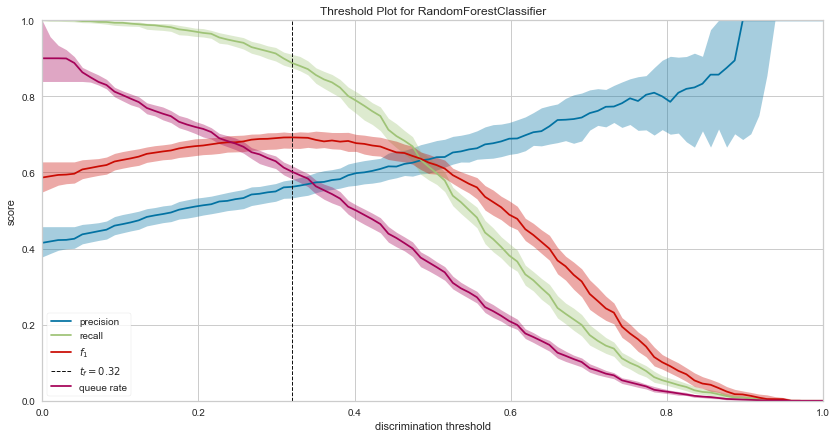

--- 92.59371304512024 seconds ---


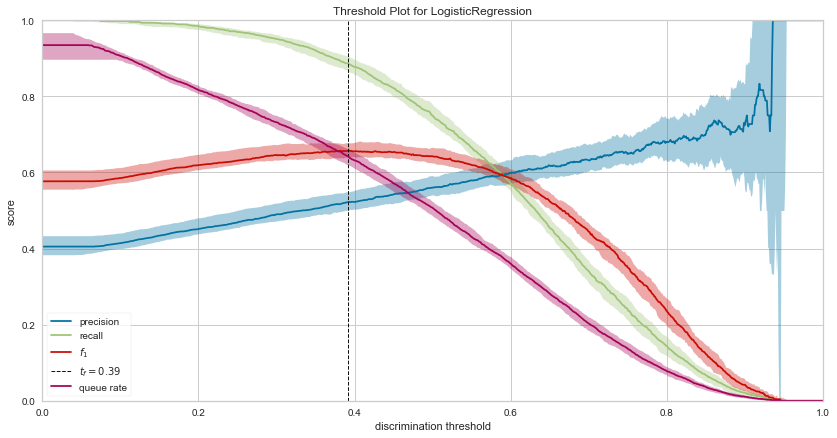

--- 10.315421104431152 seconds ---


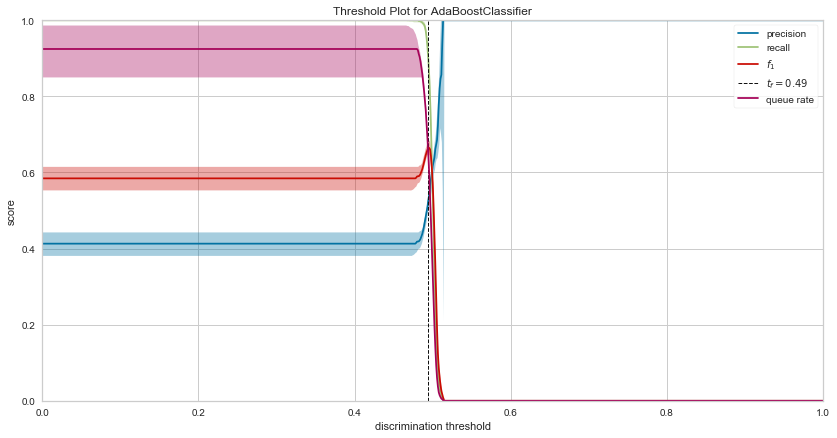

--- 32.831154346466064 seconds ---


In [42]:
from yellowbrick.classifier import DiscriminationThreshold
def vizerror(name, model):
    pipe_mdl = make_pipeline(QuantileTransformer(),
                        #PCA(n_components=6),
                        model)
    _,ax = plt.subplots(figsize=(14,7))
    visualizer = DiscriminationThreshold(pipe_mdl)
    visualizer.fit(X, Y)  # Fit the training data to the visualizer
    visualizer.poof() 
    
    
for name, model in models:
    start_time = time.time()
    vizerror(name, model)
    print('--- %s seconds ---' % (time.time() - start_time))